In [173]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from factor_analyzer import Rotator
import matplotlib.pyplot as plt
import seaborn as sb
import plotter_lib as pl

colores_ref={
    "rojo":"#dc143cff",
    "verde":"#1c681cff",
    "azul":"#4682b4ff",
    "naranja":"#ff4500ff",
}


### Datos de cada BPI

Defino las rutinas para capturar las métricas,

In [174]:
def direct_play(x):

    maxi,pos=0,[]

    for i in range(len(x)-1):

        e1,e2 = x[i],x[i+1]


        dt = (e2["eventSec"]-e1["eventSec"])

        if dt>2:

            if e1["eventName"]=="Pass" or e1["eventName"]=="Free Kick":

                dist_vertical = (e2['positions'][0]['x']- e1['positions'][0]['x'])/dt

                if dist_vertical>maxi:
                    maxi=dist_vertical
                


    return maxi


def counterattack(x):

    x0, xf = x[0]["positions"][0]["x"], x[-1]["positions"][0]["x"]

    if x0<40 and xf>60:

        dt = x[-1]["eventSec"]-x[0]["eventSec"]

        if dt>0:

            v = (xf-x0)/dt
            return v
        
    
    return 0


def T_maintenance(x):
    
    dt = x[-1]['eventSec'] - x[0]['eventSec']

    if dt>2:

        if np.mean([ e['positions'][0]['x'] for e in x])<40:
            return dt
        
        else:
            return 0.0
    
    else:
        return 0.0
    

def T_build_up(x):

    dt = x[-1]['eventSec'] - x[0]['eventSec']

    if dt>2:

        if np.mean([ e['positions'][0]['x'] for e in x])>60:
            return dt
        
        else:
            return 0.0
    
    else:
        return 0.0


def T_zona_media(x):

    dt = x[-1]['eventSec'] - x[0]['eventSec']

    if dt>2:

        xm = np.mean([ e['positions'][0]['x'] for e in x])

        if xm<=60 and xm>=40:
            return dt
        else:
            return 0.0
    
    else:
        return 0.0


def flow_rate(x):

    R,T=[],[]

    for i in range(len(x)-1):

        e1,e2 = x[i], x[i+1]
        dt = e2["eventSec"]-e1["eventSec"] 

        if dt>0:
            T.append(dt)
            R.append( e1['positions'][0]['x'] )

    if len(T) and len(R):

        dtmean = np.mean(T)

        if np.mean(R)>50:# and dtmean<5:
        
            return 1.0/dtmean
   

    return 0.0
    

def crossing(x):

    for i in range(len(x)):

        e1= x[i]

        if e1["subEventName"]=="Cross":
            return 1

    return 0


def pressure_point(x, Tant):

    if Tant>2:

        xp = x[0]['positions'][0]['x']

        return xp 
    else:
        return 0.0


def pressure_loss(x,Tant):

    if Tant>2 and x[0]['positions'][0]['x']>40:

        return Tant 
    
    else:
        return 0
    

def shots(x):

    if np.mean([ e['positions'][0]['x'] for e in x])>50:

        for e in x:
            if e["eventName"]=="Shot":
                return 1
    
    return 0


tomo los datos,

In [175]:
Data={
    "direct_play":[],
    "counterattack":[],
    "T_maintenance":[],
    "T_build_up":[],
    "T_zona_media":[],
    "flow_rate":[],
    "crossing":[],
    "pressure_point":[],
    "pressure_loss":[],
    "shots":[],

    "match":[],
    "team1":[],
    "liga":[]
}

ligas = ["England","France","Germany", "Italy", "Spain"]

for liga in ligas:

    print (liga)

    eventos = json.load(open("/home/chacoma/Lineas/Futbol/raw_data/pappalardo/events/events_%s.json"%liga,'r'))
    N=len(eventos)

    count=0
    posesion = []
    Tpos_ant=0
    team_ant =''
    eant={"eventName":""}

    for i in range(N-1):

        e1 = eventos[i]
        e2 = eventos[i+1]

        if e1['matchId']==e2['matchId']:
			
            if e1['matchPeriod']==e2['matchPeriod']:

                if e1['teamId']==e2['teamId']:
                    posesion.append(e1)
                
                else:
                    posesion.append(e1)

                    if len(posesion)>3:

                        team1 = e1['teamId']
                        match= e1["matchId"]

                        d1 = direct_play(posesion)
                        d2 = counterattack(posesion)
                        d3 = T_maintenance(posesion)
                        d4 = T_build_up(posesion)
                        d5 = T_zona_media(posesion)
                        d6 = flow_rate(posesion) 
                        d7 = crossing(posesion)
                        d8 = pressure_point(posesion, Tpos_ant)
                        d9 = pressure_loss(posesion,Tpos_ant)
                        d10 = shots(posesion)
                        

                        if (d1+d2+d3+d4+d5+d6+d7+d8+d9+d10) >0.1:
                            
                            Data["direct_play"].append(d1)
                            Data["counterattack"].append(d2)
                            Data["T_maintenance"].append(d3)
                            Data["T_build_up"].append(d4)
                            Data["T_zona_media"].append(d5)
                            Data["flow_rate"].append(d6)
                            Data["crossing"].append(d7)
                            Data["pressure_point"].append(d8)
                            
                            if team1!=team_ant and team1!='':
                                Data["pressure_loss"].append(d9)
                            else:
                                Data["pressure_loss"].append(0)
                            
                            Data["shots"].append(d10)

                            Data["match"].append(match)
                            Data["team1"].append(team1)
                            Data["liga"].append(liga)    

                    # ----------
                    
                    if len(posesion):
                        if e1['matchId']==e2['matchId']:
                            Tpos_ant= e2["eventSec"] - posesion[0]["eventSec"]
                            team_ant = team1
                        else:
                            Tpos_ant=0
                            team_ant =''
                    else:
                        Tpos_ant=0
                        team_ant =''
                        
                    posesion = []

            else:
                posesion = []
        
        else:
                posesion = []


df0 = pd.DataFrame.from_dict(Data)

df0["liga"]= df0['liga'].astype('category')

df0.head()


England
France
Germany
Italy
Spain


,direct_play,counterattack,T_maintenance,T_build_up,T_zona_media,flow_rate,crossing,pressure_point,pressure_loss,shots,match,team1,liga
0,13.798826,0.0,0.000000,0.000000,9.790285,0.000000,0,0.0,0.000000,0,2499719,1609,England
1,0.000000,0.0,0.000000,0.000000,5.661206,0.529922,0,0.0,0.000000,0,2499719,1609,England
2,0.000000,0.0,6.901369,0.000000,0.000000,0.000000,0,24.0,0.000000,0,2499719,1631,England
3,3.621163,0.0,0.000000,7.822331,0.000000,0.511357,1,0.0,0.000000,1,2499719,1609,England
4,0.000000,0.0,0.000000,11.391057,0.000000,0.263364,1,100.0,2.566969,0,2499719,1631,England


Como las columnas siguen aproximadamente una distribución lognormal, transformo a log(1+x) para trabajar con distribuciones normales

In [176]:
exclude_columns = ['liga', 'match', 'team1', "crossing", "shots"]

cols = df0.columns.difference(exclude_columns)

df1 = df0.copy(deep=True)

df1[cols] = np.log1p(df1[cols])                 # transormo features a log(1+x)

print (df1.shape)
df1.head()

(215681, 13)


,direct_play,counterattack,T_maintenance,T_build_up,T_zona_media,flow_rate,crossing,pressure_point,pressure_loss,shots,match,team1,liga
0,2.694548,0.0,0.000000,0.000000,2.378646,0.000000,0,0.000000,0.000000,0,2499719,1609,England
1,0.000000,0.0,0.000000,0.000000,1.896301,0.425217,0,0.000000,0.000000,0,2499719,1609,England
2,0.000000,0.0,2.067036,0.000000,0.000000,0.000000,0,3.218876,0.000000,0,2499719,1631,England
3,1.530646,0.0,0.000000,2.177286,0.000000,0.413008,1,0.000000,0.000000,1,2499719,1609,England
4,0.000000,0.0,0.000000,2.516975,0.000000,0.233778,1,4.615121,1.271716,0,2499719,1631,England


### Data agregada por partido y por equipo

In [177]:
def f(x):
    
    if x.name=="liga":
        return list(set(x))[0]

    
    elif x.name=="crossing" or x.name=="shots":  
        return np.sum(x)

    else:
        return np.sum(x)


df2 = df1.groupby(["match","team1" ]).agg( lambda x: f(x)).reset_index()#.drop("match", axis=1)


# una vex contados todos los centros y tiros del partido transformo a log
df2["crossing"]= np.log1p(df2["crossing"])
df2["shots"]= np.log1p(df2["shots"])



# Escaleo de las variables ------------
exclude_columns = ['liga', 'team1', 'match', "rank"]                                             # Columnas a excluir del escalado

columns_to_scale = df2.columns.difference(exclude_columns)

scaler = StandardScaler()                                                               # Crear un StandardScaler

df2[columns_to_scale] = scaler.fit_transform(df2[columns_to_scale])                     # Seleccionar solo las columnas que queremos escalar

print (df2.shape)

df2.tail()

(3652, 13)


,match,team1,direct_play,counterattack,T_maintenance,T_build_up,T_zona_media,flow_rate,crossing,pressure_point,pressure_loss,shots,liga
3647,2576336,3315,-0.125349,0.528804,-0.151589,0.667163,-0.846297,0.034914,0.264017,-0.223444,1.001169,1.109736,Italy
3648,2576337,3164,0.422704,1.373767,-0.116900,-0.085524,1.728833,0.350729,0.023985,0.780674,-0.582299,-2.056307,Italy
3649,2576337,3204,-1.165140,-1.009447,-1.215307,-0.366693,-0.615251,-0.352902,-0.981960,-1.182840,0.110486,0.393279,Italy
3650,2576338,3185,-0.792808,-0.891117,1.345147,-1.299499,-1.108084,-1.269483,-1.499088,-0.412187,-0.707438,-0.831514,Italy
3651,2576338,3193,1.367505,1.005242,0.923894,2.800833,0.219256,1.890200,0.836458,1.611067,0.530269,0.393279,Italy


In [178]:
#df2.to_csv("metrics.csv",index=False)

### PCA

In [179]:
df_data = df2.drop(columns=['match', "team1",'liga'])
categorias = df2['liga']


# Paso 1: Realizar el PCA completo
pca_full = PCA(whiten=True,n_components=df_data.shape[1])
pca_full.fit(df_data)

PCA(n_components=10, whiten=True)

Media de la varianza explicada: 0.1
Grafico de la varianza explicada:


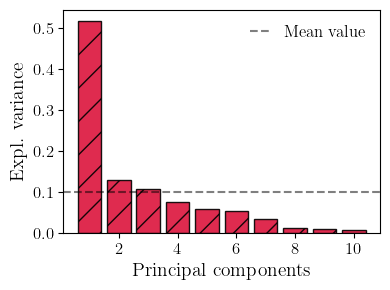

In [180]:
# Paso 2: Varianza explicada por cada componente
explained_variance = pca_full.explained_variance_ratio_

# Paso 3: Calcular la media de la varianza explicada
mean_explained_variance = explained_variance.mean()
print("Media de la varianza explicada:", mean_explained_variance)

print ("Grafico de la varianza explicada:")
plot = pl.Plotter()
plot.ax.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.9, color= colores_ref["rojo"], hatch='/', edgecolor='black')
plot.ax.axhline(mean_explained_variance, linestyle='--', color='black', alpha=0.5, label='Mean value')
plot.ax.set_xlabel('Principal components', fontsize=14)
plot.ax.set_ylabel('Expl. variance', fontsize=14)
plot.show("")

varianza explicada acumulada, para ver cuántos componentes capturan suficiente varianza


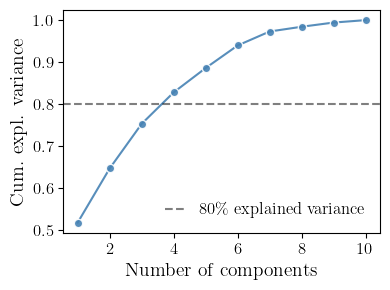

In [181]:
# grafico cum varianza
print ("varianza explicada acumulada, para ver cuántos componentes capturan suficiente varianza")
cumulative_variance = np.cumsum(explained_variance)
plot = pl.Plotter()
plot.ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', c= colores_ref["azul"], markeredgecolor='white', alpha=0.9)
#plot.ax.axvline(4, linestyle='--', color='b', alpha=0.5)
plot.ax.axhline(y=0.8, color='black', linestyle='--', label=r'$80\%$ explained variance', alpha=0.5)
#plot.ax.axhline(y=0.9, color='g', linestyle='--', label='90% Varianza')
plot.ax.set_xlabel("Number of components", fontsize=14)
plot.ax.set_ylabel("Cum. expl. variance", fontsize=14)
#plot.ax.legend()
plot.show("",loc=4)

#### loadings

In [182]:
nc=4

loadings_df = pd.DataFrame(pca_full.components_[:nc].T, index=df_data.columns, columns=[f'PC{i+1}' for i in range(nc)])

loadings_df 

,PC1,PC2,PC3,PC4
direct_play,0.405414,0.258629,-0.003056,0.053468
counterattack,0.313877,0.148546,-0.362965,0.191440
T_maintenance,0.108554,0.759048,-0.007066,-0.374025
T_build_up,0.355107,-0.301636,-0.111150,-0.015848
T_zona_media,0.360422,0.130642,0.126633,0.273552
flow_rate,0.385036,-0.228262,0.039621,0.059407
crossing,0.292760,-0.243372,-0.196629,0.138300
pressure_point,0.403633,0.161628,0.182630,0.031254
pressure_loss,0.143773,-0.129837,0.853379,-0.133306
shots,0.227552,-0.269305,-0.194845,-0.839114


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


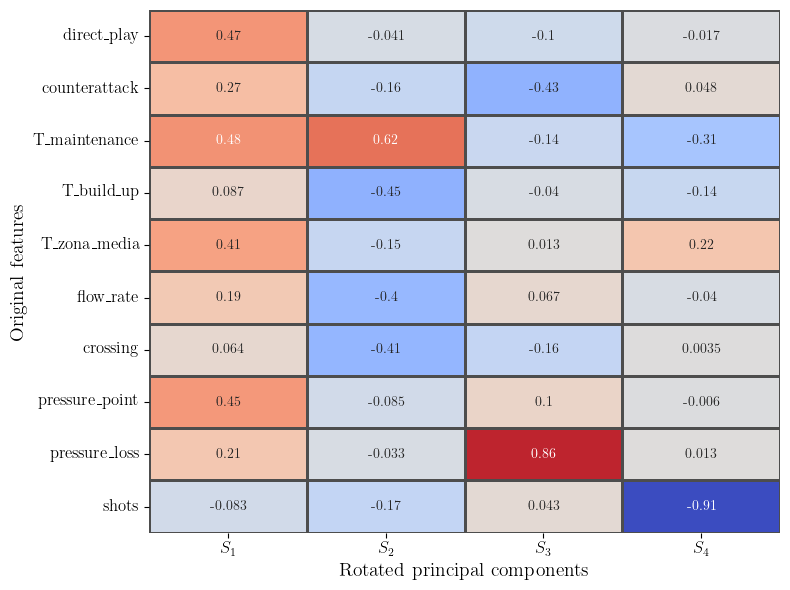

In [183]:
# Extraer los componentes seleccionados de la matriz de componentes originales
selected_components = [i for i in range(nc)]
selected_loadings = pca_full.components_.T[:,selected_components ]


# Aplicar rotación varimax a las cargas de los componentes seleccionados
rotator = Rotator()
rotated_loadings = rotator.fit_transform(selected_loadings)


# Convertir el resultado rotado a un DataFrame para visualizar mejor
rotated_loadings_df = pd.DataFrame(rotated_loadings,index=df_data.columns, columns=[f'S{i+1}' for i in range(len(selected_components))])


plot = pl.Plotter(W=8, H=6)

sb.heatmap(rotated_loadings_df, annot=True, cmap='coolwarm', center=0, 
            linewidths=0.75, linecolor='#4d4d4d', ax=plot.ax, cbar=False)#,  cbar_kws={'label': 'Cargas'})


plot.ax.set_xticklabels( [ f"$S_{i+1}$" for i in range(nc)] )

plot.ax.set_xlabel("Rotated principal components", fontsize=14)
plot.ax.set_ylabel("Original features", fontsize=14)

plot.show("")

features relevantes

In [184]:
for c in rotated_loadings_df:
    v = rotated_loadings_df[c].abs()
    mu = v.mean()
    sd = 0#v.std()

    print (c,mu)
    print(v.sort_values(ascending=False)[v>(mu+sd)])
    print ("\n")


S1 0.2723422414488493
T_maintenance     0.480977
direct_play       0.471174
pressure_point    0.453127
T_zona_media      0.409650
Name: S1, dtype: float64


S2 0.2515200386353469
T_maintenance    0.616114
T_build_up       0.447360
crossing         0.414647
flow_rate        0.403936
Name: S2, dtype: float64


S3 0.19606265142431945
pressure_loss    0.858431
counterattack    0.434440
Name: S3, dtype: float64


S4 0.17124793361919233
shots            0.910520
T_maintenance    0.313600
T_zona_media     0.218479
Name: S4, dtype: float64




### ANOVA

In [185]:
from scipy.stats import f_oneway

# Proyectar los datos en el espacio de las componentes rotadas
data_in_rotated_pcs = np.dot(df_data, rotated_loadings)


projected_df = pd.DataFrame(data_in_rotated_pcs, columns=[f'Rotated_PC{i+1}' for i in range(rotated_loadings.shape[1])])
projected_df['Category'] = categorias #rank.apply(lambda x: 1 if x==1 or x==2 else 0) 

# Realizar un ANOVA para cada componente rotado
for component in projected_df.columns[:-1]:  # Excluye la columna de 'Category'
    groups = [projected_df[component][projected_df['Category'] == cat] for cat in projected_df['Category'].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"{component}: F-Statistic = {f_stat:.2f}, p-value = {p_value:.9f}")



Rotated_PC1: F-Statistic = 18.71, p-value = 0.000000000
Rotated_PC2: F-Statistic = 7.81, p-value = 0.000002875
Rotated_PC3: F-Statistic = 17.02, p-value = 0.000000000
Rotated_PC4: F-Statistic = 7.48, p-value = 0.000005346


### Proyección

In [186]:
# Paso 1: Proyectar los datos originales en el espacio de las componentes principales rotadas
# Obtener los datos originales centrados (el PCA se realiza sobre datos centrados)
df_centered = df_data - df_data.mean()

# Multiplicar los datos centrados por las cargas rotadas (transpuestas) para obtener la proyección
data_in_pcs = np.dot(df_centered, rotated_loadings)

# Convertir los datos proyectados en un DataFrame
projected_df = pd.DataFrame(data_in_pcs, columns=[f'S{i+1}' for i in range(data_in_pcs.shape[1])])



# Mostrar los datos proyectados
print("Datos originales en términos de las componentes principales rotadas:")

projected_df

Datos originales en términos de las componentes principales rotadas:


,S1,S2,S3,S4
0,1.193054,-2.360068,-0.858711,-2.101015
1,-3.041211,0.444480,0.290051,1.924527
2,3.031945,-3.725801,1.432200,-0.295990
3,-3.804115,1.609934,0.045357,0.939894
4,0.819422,-0.062871,-0.506048,-0.721370
...,...,...,...,...
3647,-0.234512,-0.669129,0.609442,-1.202105
3648,1.685105,-0.374855,-1.085173,2.331586
3649,-2.366315,0.292535,0.853299,-0.068725
3650,-1.140701,3.080284,-0.206408,0.288422


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


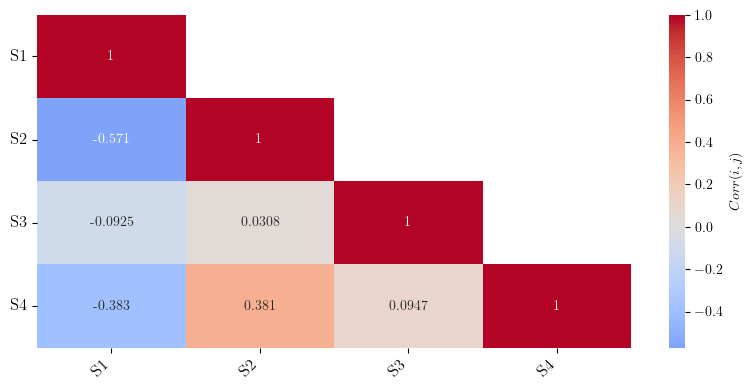

In [187]:
corr = projected_df.iloc[:,0:nc].corr()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

plot = pl.Plotter(H=4, W=8)

sb.heatmap(corr,cmap="coolwarm",mask=mask, center=0,annot=True,fmt=".3g", ax=plot.ax, cbar=True, cbar_kws={'label': '$Corr(i,j)$'})

plot.ax.set_xticklabels(plot.ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)

plot.ax.set_yticklabels(plot.ax.get_yticklabels(), rotation=0, fontsize=12)

plot.show("")

In [188]:
projected_df["match"] = df2["match"]
projected_df["team1"] = df2["team1"]
projected_df["liga"] = df2["liga"]

projected_df

,S1,S2,S3,S4,match,team1,liga
0,1.193054,-2.360068,-0.858711,-2.101015,2499719,1609,England
1,-3.041211,0.444480,0.290051,1.924527,2499719,1631,England
2,3.031945,-3.725801,1.432200,-0.295990,2499720,1625,England
3,-3.804115,1.609934,0.045357,0.939894,2499720,1651,England
4,0.819422,-0.062871,-0.506048,-0.721370,2499721,1610,England
...,...,...,...,...,...,...,...
3647,-0.234512,-0.669129,0.609442,-1.202105,2576336,3315,Italy
3648,1.685105,-0.374855,-1.085173,2.331586,2576337,3164,Italy
3649,-2.366315,0.292535,0.853299,-0.068725,2576337,3204,Italy
3650,-1.140701,3.080284,-0.206408,0.288422,2576338,3185,Italy


In [189]:
projected_df.to_csv("estilos.csv")